In [6]:
# load some packages
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import pandas as pd

from MMD_functions import *

# load the catalogue
catalogue1000 = np.load('catalogue_1000sqd.npy')

In [7]:
nside = 64 # HEALPix nside parameter

cl_kappa_225 = np.loadtxt('cl_kappa_mean_225.txt')[:,1]
cl_kappa_225 = np.concatenate((np.zeros(2), cl_kappa_225)) # add zeros for monopole and dipole
kappamap_225 = hp.synfast(cl_kappa_225, nside)
print("Cl_kappa225 shape:", cl_kappa_225.shape, "   kappamap225 shape:", kappamap_225.shape )

Cl_kappa225 shape: (10000,)    kappamap225 shape: (49152,)


In [8]:
pixscale = 0.263
sizes_in_arcsec1000 = catalogue1000['r50'] * pixscale   #arcsec

In [9]:
print( "\nrange of DEC of catalogue1000:")
print(f"[{min(catalogue1000['dec'])},{max(catalogue1000['dec'])}]" )
print( "\nrange of RA of catalogue1000:")
print(f"[{min(catalogue1000['ra'])},{max(catalogue1000['ra'])}]" )



range of DEC of catalogue1000:
[-17.89552116394043,17.89537239074707]

range of RA of catalogue1000:
[-17.928665161132812,17.927947998046875]


In [10]:
# Convert galaxy coordinates to HEALPix pixel indices
galaxy_pix1000= hp.ang2pix(nside, catalogue1000['ra'], catalogue1000['dec'], lonlat=True)
galaxy_pix1000_unique, galaxy_pix1000_counts = np.unique(galaxy_pix1000, return_counts=True)
n_pixels = hp.nside2npix(nside)

print("Galaxy pixels:",galaxy_pix1000, "   Length of Galaxy pixels(should match nr. of galaxies):", len(galaxy_pix1000))
print("Total number of galaxies:", len(catalogue1000))
print("Total number of pixels:", n_pixels)
print("Number of unique pixels with galaxies:", len(galaxy_pix1000_unique))
print("Max number of galaxies in a pixel:", np.max(galaxy_pix1000_counts))
print("Min number of galaxies in a pixel:", np.min(galaxy_pix1000_counts))
print("Mean number of galaxies in a pixel:", np.mean(galaxy_pix1000_counts))
print("Number of pixels with > 20'000 galaxies:", np.sum(galaxy_pix1000_counts >= 20000))
print('-'*30)

Galaxy pixels: [17024 17024 17024 ... 31872 31872 31872]    Length of Galaxy pixels(should match nr. of galaxies): 31574550
Total number of galaxies: 31574550
Total number of pixels: 49152
Number of unique pixels with galaxies: 1248
Max number of galaxies in a pixel: 28645
Min number of galaxies in a pixel: 1439
Mean number of galaxies in a pixel: 25300.12019230769
Number of pixels with > 20'000 galaxies: 1145
------------------------------


In [11]:
intrinsic_size1000 = sizes_in_arcsec1000
observed_size1000 = sizes_in_arcsec1000 * (1.0 + kappamap_225[galaxy_pix1000])

In [36]:
size_mask = (intrinsic_size1000 < 5.0) #arcsec


31571431


### Computing and Plotting the mean of each pixel
This is the most basic statistical measure, so we want to see, if we get a clear signal here.

Thresholds/Constraints from Noah's report:
- 20'000 galaxies per pixel for nside=64
- nside=64: In this case, the avg number of galaxies is above the needed threshold
- Outliers/Size threshold for too large galaxies: 5arcsec

In [41]:
# Apply intrinsic size mask 
size_mask = (intrinsic_size1000 < 5.0) #arcsec

galaxy_pix1000_masked = galaxy_pix1000[size_mask]
intrinsic_size1000_masked = intrinsic_size1000[size_mask]
observed_size1000_masked = intrinsic_size1000_masked* (1.0 + kappamap_225[galaxy_pix1000_masked])
galaxy_pix1000_unique_masked, galaxy_pix1000_counts_masked = np.unique(galaxy_pix1000_masked, return_counts=True)

print("Summary after applying size cut of 5 arcsec:")
print("Galaxy pixels:",galaxy_pix1000_masked, "   Length of Galaxy pixels(should match nr. of galaxies):", len(galaxy_pix1000_masked))
print("Total number of galaxies:", len(intrinsic_size1000_masked))
print("Total number of pixels:", n_pixels)
print("Number of unique pixels with galaxies:", len(galaxy_pix1000_unique_masked))
print("Max number of galaxies in a pixel:", np.max(galaxy_pix1000_counts_masked))
print("Min number of galaxies in a pixel:", np.min(galaxy_pix1000_counts_masked))
print("Mean number of galaxies in a pixel:", np.mean(galaxy_pix1000_counts_masked))
print("Number of pixels with > 20'000 galaxies:", np.sum(galaxy_pix1000_counts_masked >= 20000))
print('-'*30)

Summary after applying size cut of 5 arcsec:
Galaxy pixels: [17024 17024 17024 ... 31872 31872 31872]    Length of Galaxy pixels(should match nr. of galaxies): 31571431
Total number of galaxies: 31571431
Total number of pixels: 49152
Number of unique pixels with galaxies: 1248
Max number of galaxies in a pixel: 28645
Min number of galaxies in a pixel: 1439
Mean number of galaxies in a pixel: 25297.620993589742
Number of pixels with > 20'000 galaxies: 1145
------------------------------


In [ ]:
means_unlensed = []
means_lensed = []
pixels = []


for p in galaxy_pix1000_unique_masked:
    mask = (galaxy_pix1000_masked == p)
    if sum(mask) > 20000:   # Only consider pixels with more than 20'000 galaxies
        means_unlensed.append(np.mean(intrinsic_size1000_masked[mask]))
        means_lensed.append(np.mean(observed_size1000_masked[mask]))
        pixels.append(p)

means_unlensed = np.array(means_unlensed)
means_lensed = np.array(means_lensed)

In [26]:
mean_theory = np.mean(intrinsic_size1000)*(1.0 + kappamap_225[pixels]) 
m, b = np.polyfit(kappamap_225[pixels], means_lensed,1)
print("Fit parameters (m,b):", m, b)
print("Mean intrinsic size:", np.mean(intrinsic_size1000))

Fit parameters (m,b): 0.2996247298862678 0.317045462768339
Mean intrinsic size: 0.31698585


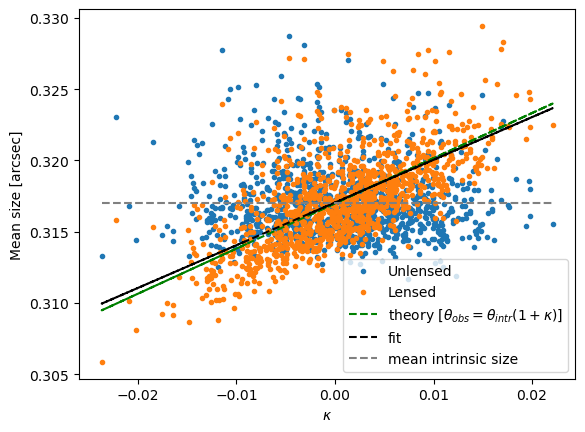

In [34]:
plt.figure()
plt.plot(kappamap_225[pixels], means_unlensed, '.', label='Unlensed')
plt.plot(kappamap_225[pixels], means_lensed, '.', label='Lensed')
plt.plot(kappamap_225[pixels], mean_theory, '--', color='g', label=r'theory $[\theta_{obs}=\theta_{intr}(1+\kappa)]$')
plt.plot(kappamap_225[pixels], m*kappamap_225[pixels]+b, '--', color='black', label='fit')
plt.plot([np.min(kappamap_225[pixels]),np.max(kappamap_225[pixels])],[np.mean(intrinsic_size1000), np.mean(intrinsic_size1000)], '--', color='grey', label='mean intrinsic size')
plt.legend()
plt.xlabel(r'$\kappa$')
plt.ylabel('Mean size [arcsec]')
plt.show()

### Now use the MMD 

In [45]:
Y = intrinsic_size1000_masked.reshape(-1,1)
X = intrinsic_size1000_masked[galaxy_pix1000_masked== galaxy_pix1000_unique[2]].reshape(-1,1)

In [46]:
print(X.shape, Y.shape)

(22701, 1) (31571431, 1)


In [ ]:
# NEW IMPLEMENTATION OF MMD FOR DIFFERENT KERNELS ---------------------------------
def compute_mmd(X, Y, kernel):
    """
    Compute Maximum Mean Discrepancy (MMD) between samples X and Y using a provided kernel.
    
    Parameters:
        X: array-like, shape (n_samples_X, n_features)
        Y: array-like, shape (n_samples_Y, n_features)
        kernel: callable, must support signature kernel(X, Y), returns kernel matrix
        
    Returns:
        mmd: float, MMD value
    """

    X = np.asarray(X)
    Y = np.asarray(Y)
    m = X.shape[0]
    n = Y.shape[0]
    
    K_XX = kernel(X, X)
    K_YY = kernel(Y, Y)
    K_XY = kernel(X, Y)
    
    # Remove diagonal for unbiased estimator
    np.fill_diagonal(K_XX, 0)
    np.fill_diagonal(K_YY, 0)
    
    mmd2 = (K_XX.sum() / (m * (m - 1))) \
        + (K_YY.sum() / (n * (n - 1))) \
        - (2 * K_XY.sum() / (m * n))
    
    return mmd2


def compute_mmd_subsample(X, Y, kernel, size_X=1000, size_Y=1000, n_iter=10, random_state=None):
    """
    Compute MMD between large X and Y by random subsampling.
    Parameters:
        X: array-like (N_X, features), large dataset
        Y: array-like (N_Y, features), large dataset
        kernel: callable kernel (scikit-learn compatible)
        size_X: int, subsample size from X
        size_Y: int, subsample size from Y
        n_iter: int, number of repetitions
        random_state: int or None, reproducibility
    Returns:
        avg_mmd: float, average MMD over n_iter subsamples
        mmd_values: list of individual MMD values
    """
    rng = np.random.default_rng(random_state)
    mmd_values = []
    for i in range(n_iter):
        Xs = rng.choice(X, size_X, replace=False)
        Ys = rng.choice(Y, size_Y, replace=False)
        mmd = compute_mmd(Xs, Ys, kernel)
        mmd_values.append(mmd)
    return np.mean(mmd_values)


In [86]:
import random
pixels=np.array(pixels)
idx = np.random.choice(range(len(pixels)), size=100, replace=False)
sub_pixel = np.array(pixels)[idx] # Von diesen Pixel berechnen wir MMD
print(pixels.size)


1145


In [82]:
mmds_list = []
pixel_list =[]
Y = intrinsic_size1000_masked.reshape(-1,1)
for p in sub_pixel:
    mask = (galaxy_pix1000_masked == p)
    if mask.sum() > 20000:
        X = intrinsic_size1000_masked[mask].reshape(-1,1)
        mmds_list.append(compute_mmd_subsample(X,Y, linear_kernel, size_X=20000, size_Y=20000, n_iter=5, random_state=42))
        pixel_list.append(p)

mmds_list= np.array(mmds_list)
pixel_list=np.array(pixel_list)


In [88]:
mmds_lensed_list = []
Y_lensed = observed_size1000_masked.reshape(-1,1)
for p in sub_pixel:
    mask = (galaxy_pix1000_masked==p)
    if mask.sum()>20000:
        X = observed_size1000_masked[mask].reshape(-1,1)
        mmds_lensed_list.append(compute_mmd_subsample(X, Y_lensed, linear_kernel, 20000,20000,5,42))

mmds_lensed_list= np.array(mmds_lensed_list)

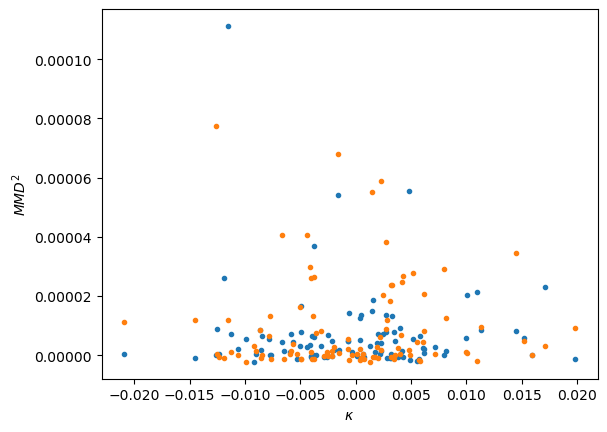

In [126]:
plt.figure()
plt.plot(kappamap_225[pixel_list], mmds_list, '.', label='unlensed')
plt.plot(kappamap_225[pixel_list], mmds_lensed_list, '.', label='lensed')#NEW
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$MMD^2$')
plt.show()

### Implementation of the MMD using PyTorch for faster computation

In [122]:
import torch
print(torch.cuda.is_available())

def compute_mmd_torch(X, Y, kernel_fn):
    """
    Compute unbiased (squared) Maximum Mean Discrepancy in PyTorch.
    Arguments:
      X: torch.Tensor of shape [m, d]
      Y: torch.Tensor of shape [n, d]
      kernel_fn: callable (X, Y) -> [m, n] kernel matrix
      
    Returns:
      mmd2: torch.Tensor, squared MMD statistic (scalar)
    """
    m, n = X.size(0), Y.size(0)
    K_XX = kernel_fn(X, X)
    K_YY = kernel_fn(Y, Y)
    K_XY = kernel_fn(X, Y)

    # Remove diagonal for unbiased estimator
    K_XX = K_XX.clone()
    K_YY = K_YY.clone()
    K_XX.fill_diagonal_(0)
    K_YY.fill_diagonal_(0)
    
    mmd2 = (K_XX.sum() / (m * (m - 1))) \
        + (K_YY.sum() / (n * (n - 1))) \
        - (2. * K_XY.sum() / (m * n))
    return mmd2

def linear_kernel(A, B):
    return torch.matmul(A, B.t())

def rbf_kernel(X, Y, gamma=1.0):
    """
    Compute RBF (Gaussian) kernel matrix in PyTorch.
    K(x, y) = exp(-gamma * ||x - y||^2)
    Inputs:
      X: [m, d] tensor
      Y: [n, d] tensor
      gamma: positive float (kernel bandwidth, 1/(2*sigma^2))
    Returns:
      K: [m, n] tensor, kernel matrix
    """
    # Compute squared Euclidean distances
    X_norm = (X ** 2).sum(dim=1).view(-1, 1)
    Y_norm = (Y ** 2).sum(dim=1).view(1, -1)
    dists = X_norm + Y_norm - 2.0 * torch.mm(X, Y.t())
    K = torch.exp(-gamma * dists)
    return K

def random_subsamples(X_all , size_X, random_state=None):
    """
    Randomly select subsamples from two tensors.
    X_all: [N, d] tensor
    Y_all: [M, d] tensor
    size_X: int, number of samples to draw from X_all
    size_Y: int, number of samples to draw from Y_all
    random_state: int or None, for reproducibility
    Returns:
      X: [size_X, d] tensor
      Y: [size_Y, d] tensor
    """
    if random_state is not None:
        torch.manual_seed(random_state)
    idx_X = torch.randperm(X_all.shape[0])[:size_X]
    # idx_Y = torch.randperm(Y_all.shape[0])[:size_Y]
    X = X_all[idx_X]
    # Y = Y_all[idx_Y]
    return X



False


In [123]:
Y = random_subsamples(torch.tensor(observed_size1000_masked.reshape(-1,1), device="cpu"),20000, random_state=42)
X = random_subsamples(torch.tensor(observed_size1000_masked[galaxy_pix1000_masked== galaxy_pix1000_unique[2]].reshape(-1,1), device="cpu"),20000, random_state=42)


mmd_value = compute_mmd_torch(X, Y, linear_kernel)
print("MMD value:", mmd_value.item())


MMD value: -2.3245811462402344e-06


### Try again MMD using MC on large data set 
Check how long it would take

In [127]:
def unbiased_Exx(X,sigma):
    """
    Compute E[k(X,X)] exactly without diagonal terms (i.e. unbiased)
    """
    inv2s2= 1.0 /(2.0*sigma**2)
    D2 = np.square(X[:, None,:] - X[None, :, :]).sum(axis=2)
    np.fill_diagonal(D2,np.nan)
    return np.nanmean(np.exp(-inv2s2*D2))

def MC_Eyy(Y, sigma, n_pairs=200_000, rng=None):
    """
    Compute E[k(Y,Y)] by sampling many distinct pairs from Y. (Monte Carlo)
    """
    rng = np.random.default_rng() if rng is None else rng
    n = Y.shape[0]
    i = rng.integers(0, n, size=n_pairs)
    j = rng.integers(0, n-1, size=n_pairs)
    j = j + (j >= i)  # ensure j != i
    inv2s2 = 1.0 / (2.0 * sigma * sigma)
    D2 = np.square(Y[i] - Y[j]).sum(axis=1)
    return np.mean(np.exp(-inv2s2 * D2))

def MC_Exy(X, Y, sigma, n_pairs=1_000_000, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    X = np.atleast_2d(X); Y = np.atleast_2d(Y)
    m, n = X.shape[0], Y.shape[0]
    ix = rng.integers(0, m, size=n_pairs)
    jy = rng.integers(0, n, size=n_pairs)
    diff = X[ix] - Y[jy]
    inv2s2 = 1.0 / (2.0 * sigma * sigma)
    d2 = np.einsum('nd,nd->n', diff, diff)
    return float(np.mean(np.exp(-inv2s2 * d2)))


def mean_rbf_xy(X, Y, sigma, block=500_000):
    """
    Compute E[k(X,Y)] exactly without storing full Gram matrix (uses rbf kernel)
    """
    inv2s2 = 1.0 / (2.0 * sigma * sigma)
    m = X.shape[0]; n = Y.shape[0]
    total = 0.0; count = 0
    for s in range(0, n, block):
        Yb = Y[s:s+block]
        X2 = np.sum(X**2, axis=1, keepdims=True)      # (m,1)
        Y2 = np.sum(Yb**2, axis=1, keepdims=True).T   # (1,|b|)
        D2 = X2 + Y2 - 2 * X @ Yb.T
        K = np.exp(-inv2s2 * D2)
        total += K.sum(); count += K.size
    return total / count

#Compute the MMD using the above 4 functions
def mmd2_biased_fast(X, Y, sigma, n_pairs_yy=200_000):
    """
    Suitable for small X and large Y. If X becomes large too using a different galaxy catalogue,
    consider changing this function to compute E_XX also using MC.
    """
    exx = unbiased_Exx(X, sigma) if len(X)<5000 else MC_Eyy(X,sigma,n_pairs_yy)                 # tiny (m~100)
    exy = mean_rbf_xy(X, Y, sigma)               # exact mean, blockwise
    eyy = MC_Eyy(Y, sigma, n_pairs_yy)           # Monte-Carlo
    return exx + eyy - 2.0 * exy

#Helperfunction to find a good value of sigma for the rbf kernel using median heuristic approach
def sigma_median(X, Y, max_y=5000, rng=None, eps=1e-12):
    rng = np.random.default_rng() if rng is None else rng
    Yc = Y if Y.shape[0] <= max_y else rng.choice(Y.ravel(), size=max_y, replace=False).reshape(-1,1)
    Z = np.vstack([X, Yc])
    D2 = (Z[:,None,:] - Z[None,:,:])**2
    tri = D2[np.triu_indices_from(D2[:,:,0], k=1)]
    med = np.median(tri[tri > 0])
    return float(np.sqrt(max(med, eps)))

#Same Helperfunction as above but for very large Y and X is a subsample of Y.
def sigma_median_pairs(Y, n_pairs=1_000_000, rng=None, eps=1e-12):
    """
    Global RBF bandwidth σ by the median heuristic:
      σ^2 ≈ median( ||y_i - y_j||^2 ) over randomly sampled i≠j pairs from Y.
    Works for shape (n,) or (n,d). O(n_pairs·d) time, O(n_pairs) memory.
    """
    rng = np.random.default_rng() if rng is None else rng
    Y = np.asarray(Y)
    if Y.ndim == 1:
        Y = Y[:, None]  # (n,1)

    n = Y.shape[0]
    i = rng.integers(0, n, size=n_pairs)
    j = rng.integers(0, n - 1, size=n_pairs)
    j = j + (j >= i)  # ensure i != j

    diffs = Y[i] - Y[j]                 # (n_pairs, d)
    d2 = np.einsum('nd,nd->n', diffs, diffs)  # squared norms
    med = np.median(d2[d2 > 0]) if np.any(d2 > 0) else 0.0
    return float(np.sqrt(max(med, eps)))      # returns σ (not σ^2)


def get_MMDs(size_distr, galaxy_pixels, n_gal=100, 
             sigma= None, n_pairs_yy = 200_000,n_pairs_xy=1_000_000, rng=None):
    """
    Input:
    size_distr: Array with the sizes of all galaxies (preferably converted into arcsec). 
                -> catalogue['r50']*pixscale
    galaxy_pix: Array with the number of the pixel at which each galaxy is located.
    n_gal:  Threshold number for which the MMD is computed for a pixel. 
            If there are not enough galaxies in the pixel, the MMD will not be computed.

    Output:
    MMDs: np.array of the MMDs between the galaxy size distribution in a pixel and the whole distr
    pixels: np.array of the pixel numbers for which the MMD was computed. Can later be used to get 
            the corresponding kappa value for these pixels.
    """
    rng = np.random.default_rng() if rng is None else rng
    Y= size_distr.reshape(-1,1) # Sizes of all galaxies in the right format to work with sklearn

    # #Fix sigma globally if not provided
    # if sigma is None:
    #     sigma = sigma_median_pairs(Y,rng=rng)

    #Precompute E[k(Y,Y)] once (using MC)
    Eyy = MC_Eyy(Y,sigma, n_pairs=n_pairs_yy, rng=rng)

    unique_pixels = np.unique(galaxy_pixels)
    mmd_list =[]
    pix_list = []
    # n_pix= hp.nside2npix(nside) # Number of pixels

    for pixel in unique_pixels:
        mask = (galaxy_pixels == pixel)
        m = int(mask.sum())
        if m < max(n_gal, 2):
            continue

        X = size_distr[mask].reshape(-1,1)   # Size of all galaxies in the pixel nr. {pixel}
        
        #E[k(X,X)] - exact for small X, else MC
        if m < 3000:
            Exx = unbiased_Exx(X, sigma)
        else: 
            Exx = MC_Eyy(X,sigma, n_pairs=min(200_000, m*(m-1)), rng=rng)


        # E[k(X,Y)] – exact mean via blocks
        Exy = MC_Exy(X,Y,sigma, n_pairs=n_pairs_xy ,rng=rng)

        mmd2 = Exx + Eyy -2.0*Exy
        # mmd = np.sqrt(np.maximum(mmd2, 0.0))
        pix_list.append(pixel)   # List of the pixels for which MMD was computed, later used to get the right kappa values
        mmd_list.append(mmd2)


    return np.array(mmd_list), np.array(pix_list)


In [138]:
sigma = sigma_median_pairs(intrinsic_size1000_masked, 2_000_000)
mmds_unlensed, pixels_unlensed = get_MMDs(intrinsic_size1000_masked, galaxy_pix1000_masked, n_gal=20000, sigma=sigma, n_pairs_yy=20_000_000, n_pairs_xy=100_000_000)
mmds_lensed, pixels_lensed = get_MMDs(observed_size1000_masked, galaxy_pix1000_masked, n_gal=20000, sigma=sigma, n_pairs_yy=20_000_000, n_pairs_xy=100_000_000)

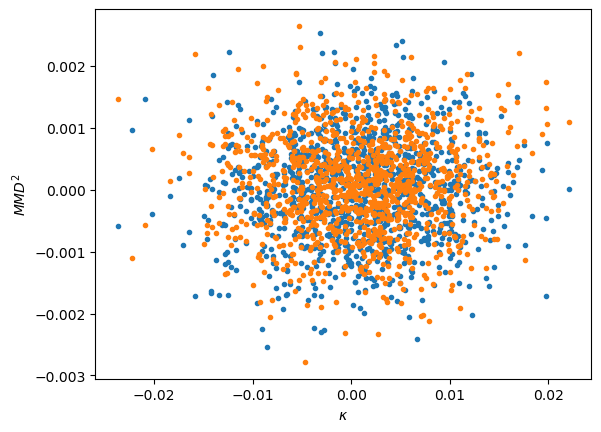

In [139]:
plt.figure()
plt.plot(kappamap_225[pixels_unlensed], mmds_unlensed, '.', label='unlensed')
plt.plot(kappamap_225[pixels_lensed], mmds_lensed, '.', label='lensed')
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$MMD^2$')
plt.show()